In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))

# Getting tokens

To tokenize the descriptions we'll need a function that tokenizes a string and removes undesired words and characters. We'll use the NLTK library for this.

In [12]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from string import punctuation

stopwords = stopwords.words('english')
punctuation = list(punctuation)
ps = PorterStemmer()


# Convert a piece of text into tokens
# With stemming, punctuation removal, stopword removal, and digit removal etc.
def get_tokens(text):
    tokens_raw_lower = word_tokenize(text.lower())
    try:
        tokens = []
        for token in tokens_raw_lower:
            if token.isdigit(): # Remove digits
                continue
            elif token in punctuation or token in ["'s","’",".","--"] or token in stopwords: # Remove punctuation and stopwords
                continue
            
            token = ps.stem(token)
            tokens.append(token)
        return tokens
    except: return []

With this get_tokens function it's now possible to get the tokens, but unfortunately the returned words are stemmed which doesn't look nice and is only relevant for getting the TF-IDF of unique words. And since we still want to be able to display some beautiful Wordclouds with actual words that match (as best as possible) the original words we therefore choose the most frequent and therefore most likely original version of the stemmed word, and replace it with that.

In [3]:
import pandas as pd
from ast import literal_eval

from collections import defaultdict, Counter
from statistics import mode


# Loading the descriptions dataset:
character_data = pd.read_csv('ProjectA/descriptions.csv', sep=";", usecols=[1, 2, 3, 4, 5], converters={4: literal_eval})
character_data.set_index("name", inplace=True)
character_data = character_data.sort_index()

# Tokenizing the entire corpus:
star_wars_vocab = word_tokenize(" ".join(character_data["description"]).lower())
# Making the dictionary of connections between stemmed words and the "original" words:
star_wars_vocab_dict = defaultdict(list)
for v in star_wars_vocab:
    star_wars_vocab_dict[ps.stem(v)].append(v)
# The function to "recreate" the tokens:
token_beautifier = lambda token: mode(sorted(star_wars_vocab_dict[token])) # The "beautified" token function.

# Adding the tokens column to the dataset:
character_data["tokens"] = character_data["description"].apply(get_tokens).apply(lambda tokens: list(map(token_beautifier, tokens)))
character_data = character_data[["description", "tokens", "properties", "referrals", "history"]]

# Optionally saving the dataset:
# character_data.to_csv("ProjectA/descriptions_tokens.csv", sep=";")

# Getting character groups

To get the different desired groupings we create a defaultdict and iterate over the properties of each character, choosing the first in that list of properties as the main property. Simply choosing the first of many possiple items in a list of properties might be a bit arbitrary, but it's the best we can do for now.

In [7]:
def get_groups(property_choice, character_data=character_data):
    errors = 0
    groups_dict = defaultdict(list)
    for i in range(len(character_data)):
        character = character_data.iloc[i]
        character_prop = character["properties"]
        try:
            prop = character_prop[property_choice][0]
        except:
            errors += 1
            continue
        groups_dict[prop].append(i)

    print(f'This many characters {errors}, do not have the property: {property_choice}.')
    character_groups = [character_data.iloc[group] for group in list(groups_dict.values())]
    return character_groups

# Calculating TF-IDF

To create the TF-IDF word-frequency-dictionary for each group we first calculate the IDF of the whole corpus. Then we iterate over each group and each word in that group, adding the calculated TF-IDF for each word to the "word-frequency-dictionary".

In [9]:
import numpy as np

# TF and IDF formulas:
IDF = lambda term_count: np.log10(len(character_data) / term_count)
TF = lambda term_count, N: (term_count / N) * 100

# Finding the IDF for the whole corpus:
corpus_total_tokens = sum(character_data["tokens"].apply(set).apply(list), [])
corpus_total_tokens_count = Counter(corpus_total_tokens)
IDF_dict = {word: IDF(count) for word, count in corpus_total_tokens_count.items()}

# Function to calculate the word-frequency-dictionaries for each group in a list of communities:
def get_TF_IDF(communities, single=False):
    if single: communities = [communities]
    
    community_TF_IDF = []
    for group in communities:
        group_total_tokens = sum(group["tokens"], []) # Adding all tokens of the group together.
        group_total_tokens_count = Counter(group_total_tokens)
        
        # Calculating the TF-IDF and making it into a dictionary:
        tf_idf = {word: TF(count, len(group_total_tokens)) * IDF_dict[word] for word, count in group_total_tokens_count.items()}
        community_TF_IDF.append(dict(sorted(tf_idf.items(), key=lambda item: item[1], reverse=True)))
    
    if single: return community_TF_IDF[0]
    return community_TF_IDF

# An extra function to combine the dictionaries of multiple communities into one
# for example with the purpose of making a wordcloud of all the groups:
def combine_dictionaries(dictionaries):
    combined_dict = {}
    counts = {}
    
    for dictionary in dictionaries:
        for key, value in dictionary.items():
            if key not in combined_dict:
                combined_dict[key] = value
                counts[key] = 1
            else:
                combined_dict[key] += value
                counts[key] += 1
    for key in combined_dict:
        combined_dict[key] /= counts[key]
    
    return dict(sorted(combined_dict.items(), key=lambda item: item[1], reverse=True))

# Making wordclouds

To create the wordclouds we use the wordcloud library where we've chosen to include a Star Wars font and a relevant background image-mask of the Death Star. Furthermore we've chosen to color the words according to their TF-IDF score, and to make the wordclouds more readable we've chosen not to include words that are too small (in terms of font-size which is of course affected by TF-IDF).

In [10]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from PIL import Image


def create_wordcloud(word_frequency_dict):
    # The backgroud mask for the wordcloud:
    sw_mask = np.array(Image.open("ProjectA/images_wordclouds/death_star1.png").convert('RGB'))
    
    # The color function to decide how words are colored:
    def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return f"hsl(0, 0%, {font_size * 0.7 + 30}%)"

    # The wordcloud itself, with the mask, color function, and other parameters included:
    wordcloud = WordCloud(
        font_path="ProjectA/images_wordclouds/StarJedi.ttf", background_color="black",
        width=600, height=600, max_words=400, min_font_size=9, max_font_size=100,
        mask=sw_mask).generate_from_frequencies(word_frequency_dict)
    wordcloud = wordcloud.recolor(color_func=grey_color_func, random_state=3)

    # Finally plotting the wordcloud:
    plt.figure( figsize=(20,10), facecolor='k' );
    plt.imshow(wordcloud, interpolation='bilinear');
    plt.axis("off");

This many characters 86, do not have the property: Appearances.

Word Cloud for Star Wars: Return of the Jedi (Episode VI):


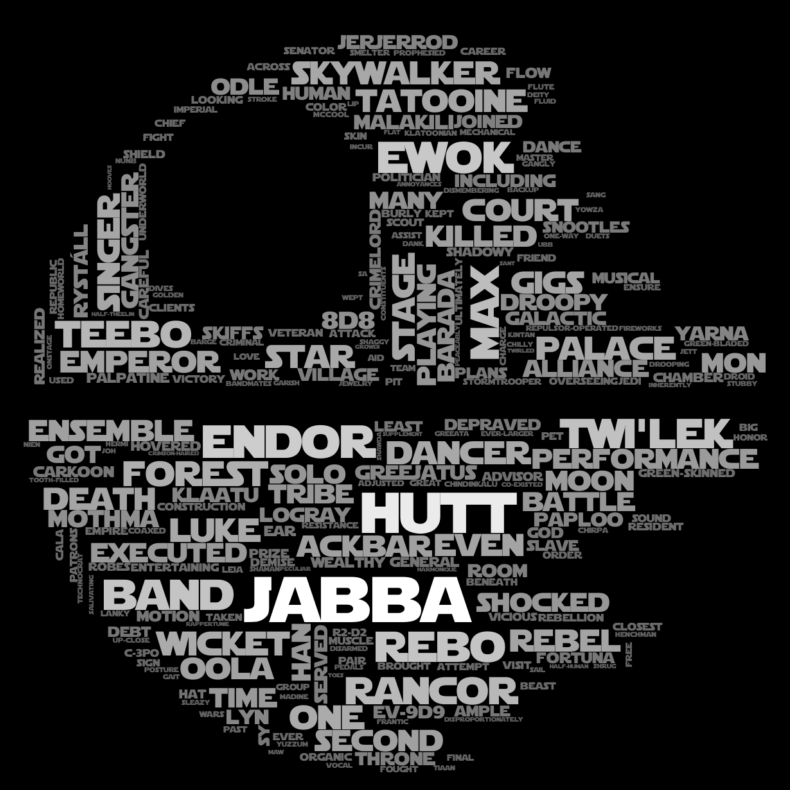

In [11]:
property_choice = "Appearances"
character_groups = get_groups(property_choice)

group_idx = 3
print(f"\nWord Cloud for {character_groups[group_idx]['properties'][0][property_choice][0]}:")

create_wordcloud(get_TF_IDF(character_groups[group_idx], single=True))